In [79]:
#<---- Dependencies ---->
import pandas as pd
import numpy as np
import scipy.stats as scs
import itertools
import operator

# Reading and cleaning

In [80]:
df = pd.read_csv("https://opendata.socrata.com/api/views/77jn-2ym9/rows.csv")

In [81]:
df.head(5)

,time,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,Location 1
0,10/28/2015 12:42:31 PM,0.85,1.50,md,8.0,144.0,0.02065,0.04,nc,nc72545285,10/28/2015 12:44:09 PM,"2km SE of The Geysers, California",earthquake,"(38.7610016, -122.7385025)"
1,10/28/2015 12:38:54 PM,8.02,1.62,ml,69.0,26.0,0.04703,0.19,ci,ci37264863,10/28/2015 12:49:38 PM,"14km WNW of Anza, California",earthquake,"(33.5886667, -116.8206667)"
2,10/28/2015 12:16:43 PM,9.49,2.04,md,13.0,92.0,0.00605,0.08,nc,nc72545275,10/28/2015 12:18:18 PM,"13km N of Laytonville, California",earthquake,"(39.8105011, -123.4886703)"
3,10/28/2015 11:56:56 AM,74.50,2.40,ml,NaN,NaN,NaN,0.80,ak,ak11756432,10/28/2015 12:40:25 PM,"34km WNW of Anchor Point, Alaska",earthquake,"(59.8767, -152.4128)"
4,10/28/2015 11:55:57 AM,2.12,1.34,ml,48.0,68.0,0.02128,0.18,ci,ci37264855,10/28/2015 12:07:16 PM,"14km NE of Yucaipa, California",earthquake,"(34.1053333, -116.9145)"


In [82]:
# Let's see how many nulls we have in this
# Dataframe
print(df.isnull().sum())

time             0
depth            0
mag              0
magType          0
nst           3142
gap           2470
dmin          2649
rms             14
net              0
id               0
updated          0
place            0
type             0
Location 1       0
dtype: int64


In [83]:
# Getting the shape, prior to a drop
df.shape

(8441, 14)

In [84]:
# Dropping null values
df = df.dropna()

In [85]:
# We lost about 3,000 observations...
# Unfortunate but I think we can still train and test
# A great model off of 5,000, especially with simple features like this.
df.shape

(5158, 14)

In [86]:
# Now let's actually take a long look at our data:
df.head(5)

,time,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,Location 1
0,10/28/2015 12:42:31 PM,0.85,1.50,md,8.0,144.0,0.02065,0.04,nc,nc72545285,10/28/2015 12:44:09 PM,"2km SE of The Geysers, California",earthquake,"(38.7610016, -122.7385025)"
1,10/28/2015 12:38:54 PM,8.02,1.62,ml,69.0,26.0,0.04703,0.19,ci,ci37264863,10/28/2015 12:49:38 PM,"14km WNW of Anza, California",earthquake,"(33.5886667, -116.8206667)"
2,10/28/2015 12:16:43 PM,9.49,2.04,md,13.0,92.0,0.00605,0.08,nc,nc72545275,10/28/2015 12:18:18 PM,"13km N of Laytonville, California",earthquake,"(39.8105011, -123.4886703)"
4,10/28/2015 11:55:57 AM,2.12,1.34,ml,48.0,68.0,0.02128,0.18,ci,ci37264855,10/28/2015 12:07:16 PM,"14km NE of Yucaipa, California",earthquake,"(34.1053333, -116.9145)"
6,10/28/2015 11:50:54 AM,13.53,0.46,ml,23.0,104.0,0.02490,0.11,ci,ci37264847,10/28/2015 11:54:34 AM,"7km NE of Anza, California",earthquake,"(33.6008333, -116.6256667)"


In [87]:
# Our target is going to be the
#   Location of the Earthquake
target = "place"

In [88]:
# There are a lot of columns in this dataframe
#    That could cause some serious leakage, or won't
#      Help our accuracy at all, so let's get rid of them.
df = df.drop(columns="updated")
# Removed for Leakage, and unimportance
df = df.drop(columns="id")
# Removed for unimportance
df = df.drop(columns="Location 1")
# Removed for unimportance, and the potential of location leakage
df = df.drop(columns="time")
# Removed for leakage, and unimportance

In [89]:
#We're going to take the [distance] south of ___ blah
#     blah, and just replace it with the State
df['State'] = df['place'].str.split(',').str[1]

In [90]:
#Now we'll drop place and keep State.
df = df.drop(columns="place")

In [91]:
# Our Clean DataFrame:
df.head(5)

,depth,mag,magType,nst,gap,dmin,rms,net,type,State
0,0.85,1.50,md,8.0,144.0,0.02065,0.04,nc,earthquake,California
1,8.02,1.62,ml,69.0,26.0,0.04703,0.19,ci,earthquake,California
2,9.49,2.04,md,13.0,92.0,0.00605,0.08,nc,earthquake,California
4,2.12,1.34,ml,48.0,68.0,0.02128,0.18,ci,earthquake,California
6,13.53,0.46,ml,23.0,104.0,0.02490,0.11,ci,earthquake,California


# Selection
Selecting the target, my features, getting some importances, exploring and making tweaks to the data, and finally Train/Test splitting my data.

In [92]:
from sklearn.model_selection import train_test_split
# Using Sklearn to Test Train Split:
test, train = train_test_split(df)

In [93]:
# Plot a histogram to see frequency per-state:
target = "State"
import plotly.express as px
import plotly.graph_objects as go
tips = px.data.tips()
fig = px.histogram(df, x="State",color_discrete_sequence=['indianred'])
fig.show()

Obviously California is the world leader here, Interestingly, some of the state data for California is stored as CA

In [94]:
df = df.replace("CA","California")

In [95]:
# The problem I could face with something like this is the potential of the
#       outcome almost always being California
#  SEE 2 CELLS BELOW:

In [96]:
# Let's make our Xs and ys to fit to our pipeline:
target = "State"
Xtrain = train.drop(columns=target)
ytrain = train[target]
Xtest = test.drop(columns=target)
ytest = test[target]

# Getting a baseline

In [97]:
# we're going to get a majority class baseline,
# to see what kind of accuracy we would get if we guessed
# California each time:

# Here's the function I wrote:
def most_common(L):
  SL = sorted((x, i) for i, x in enumerate(L))
  groups = itertools.groupby(SL, key=operator.itemgetter(0))
  def _auxfun(g):
    item, iterable = g
    count = 0
    min_index = len(L)
    for _, where in iterable:
      count += 1
      min_index = min(min_index, where)
    return count, -min_index
  return max(groups, key=_auxfun)[0]
def baseliner(y,ypr):
  r = []
  m = most_common(y)
  for i in ypr:
    r.append(m)
  return(r)

In [98]:
# Fitting and predicting with our baseline:
y_pred = baseliner(ytrain,ytest)

In [99]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(ytest,y_pred)

In [100]:
print("Baseline Accuracy:",acc)
# That's a lot lower than I was expecting!
# So that means that in total, California is
# 50 percent of the US Earthquake data.
# So a model would actually be useful for predicting this.

Baseline Accuracy: 0.5144777662874871


# MVP

In [115]:
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import xgboost as xgb
# Pipeline:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    IterativeImputer(), 
    xgb.XGBClassifier(
                n_estimators=1200,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.7,
                colsample_bytree=0.7,
                objective='reg:linear')
)

In [116]:
pipeline.fit(Xtrain,ytrain)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['magType', 'net', 'type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'magType',
                                          'data_type': dtype('O'),
                                          'mapping': md     1
ml     2
Md     3
mb     4
mw     5
NaN   -2
dtype: int64},
                                         {'col': 'net', 'data_type': dtype('O'),
                                          'mapping': nc             1
ci             2
mb             3
nn             4
uu             5
hv             6
nm             7
pr             8
uw             9
ismpkansas    10
se            11
ld            12
NaN           -2
dt...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=

In [120]:
ypr = pipeline.predict(Xtest)

In [121]:
accuracy_rf = accuracy_score(ytest,ypr)

In [122]:
print("===================================================================")
print("___Unscaled, continous encoded Xgb Classifier Accuracy___")
print("_________________________",accuracy_rf,"______________________")
print("===================================================================")

___Unscaled, continous encoded Xgb Classifier Accuracy___
_________________________ 0.9118407445708376 ______________________


In [106]:
# That's suprisingly balanced with the histogram in mind.
#    Especially with the baseline being 59, all things considered, I think
#    This'll work.
# I'm interested to see one more thing though....

In [107]:
# I'm actually suprised that the result was the same, and just as well the
# Results were correct.
# I was thinking that type would have a bigger effect.

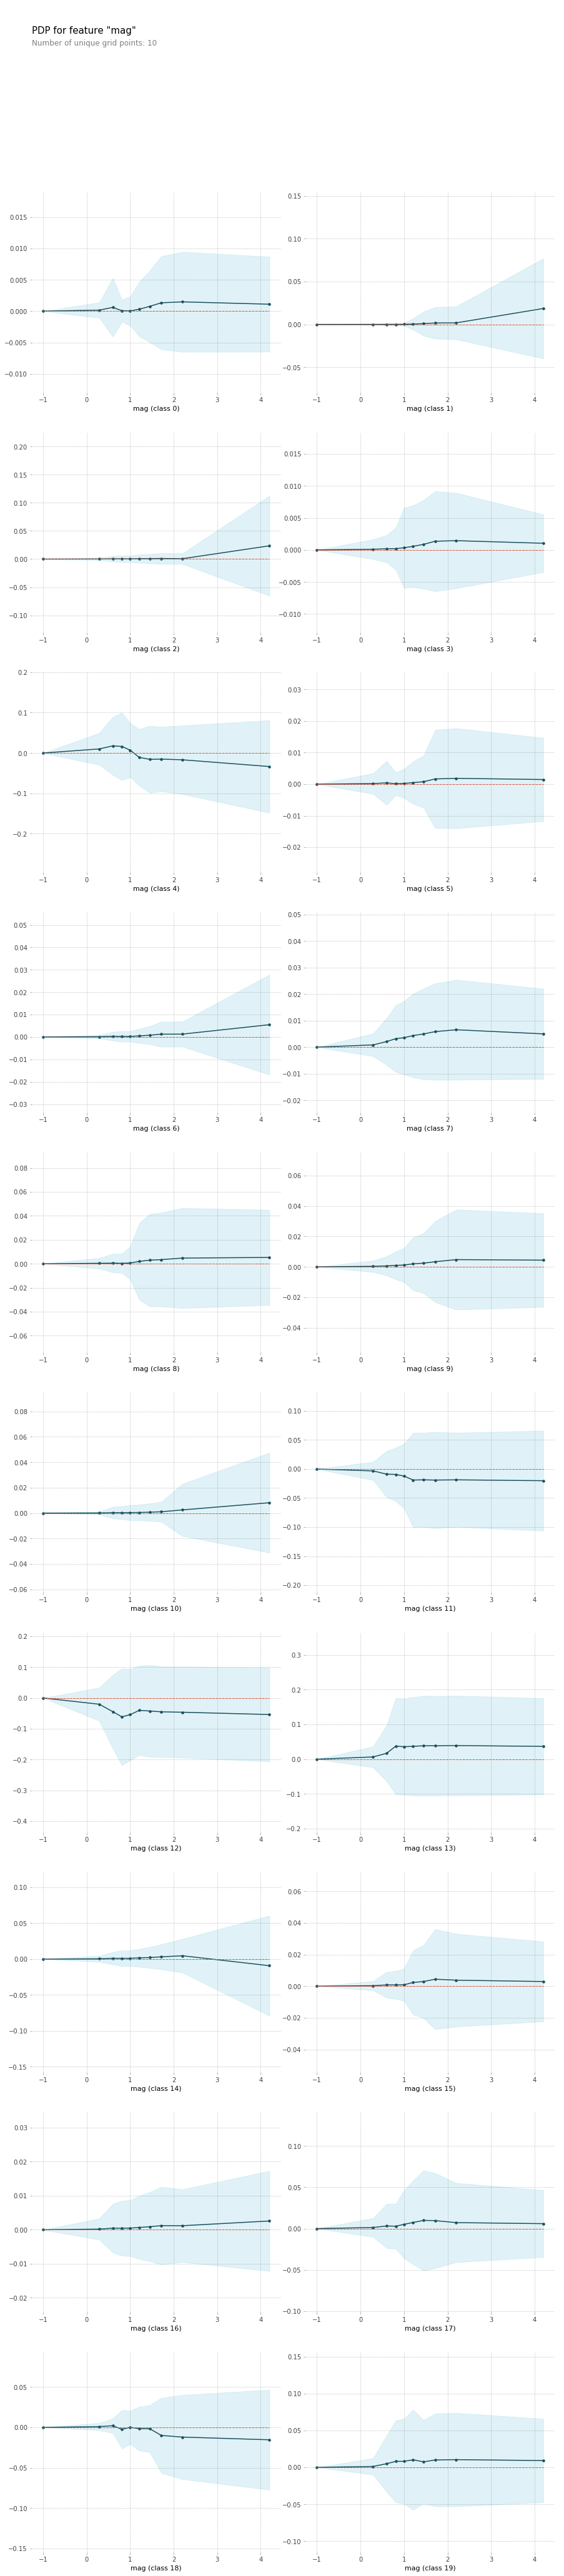

In [108]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'mag'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=Xtrain, 
    model_features=Xtrain.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [109]:
df = test.copy()
df['State'] = ypr

In [110]:
df.head(2)

,depth,mag,magType,nst,gap,dmin,rms,net,type,State
1723,-1.72,1.12,ml,29.0,72.0,0.04559,0.15,ci,quarry blast,California
6301,3.50,1.27,ml,20.0,88.0,0.22200,0.30,uu,earthquake,Utah


In [111]:
print(df['mag'])

1723    1.12
6301    1.27
7501    1.58
8328    0.26
7677    1.81
        ... 
4396    0.73
7692    0.89
6457    0.97
4682    1.44
3092    0.94
Name: mag, Length: 3868, dtype: float64


In [112]:
df['mag'] = df['mag'].astype(float)

In [113]:
import colorlover as cl
bupu = cl.scales['3']['div']['RdYlBu']

In [114]:
import plotly.express as px
iris = px.data.iris()
fig = px.scatter(df, x="mag", y="State", color="depth",
                 size='gap', hover_data=['mag'],
                title="North American Location and Earthquake magnitude",
                color_continuous_scale=bupu)
fig.show()